* Colab 에서 실행!

In [1]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [2]:
# 필요한 라이브러리 설치하기
!git clone https://github.com/ndb796/bing_image_downloader

fatal: destination path 'bing_image_downloader' already exists and is not an empty directory.


#### <b>1. 이미지 크롤링을 활용한 학습 이미지 수집</b>

* 수집한 이미지를 저장하기 위한 폴더를 생성하고, 필요한 함수를 정의합니다.

In [3]:
import os
import shutil
from bing_image_downloader.bing_image_downloader import downloader


directory_list = [
    './custom_dataset/train/',
    './custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

* <b>마동석</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다.

In [4]:
# query = '마동석'
# downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
# dataset_split(query, 30)

* <b>김종국</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다.

In [5]:
# query = '김종국'
# downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
# dataset_split(query, 30)

* <b>이병헌</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다.

In [6]:
# query = '이병헌'
# downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
# dataset_split(query, 30)

In [7]:
menu = ['밥', '죽', '국수', '만두', '떡국', '수제비']
for i in menu:
    query = i
    downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
    dataset_split(query, 30)

[Info] Indexing page: 1
[Info] Indexed 41 Images on Page 1.
#1 이미지 다운로드 (https://img.lovepik.com/element/40040/7944.png_1200.png)
#1 파일 다운로드가 완료되었습니다.
#2 이미지 다운로드 (https://img.lovepik.com/element/40039/8767.png_1200.png)
#2 파일 다운로드가 완료되었습니다.
#3 이미지 다운로드 (http://img1.daumcdn.net/thumb/R720x0/?fname=https:%2F%2Ft1.daumcdn.net%2Fliveboard%2FSNUH%2F9fb3ca294d284186852aae153fa1dd0a.png)
#3 파일 다운로드가 완료되었습니다.
#4 이미지 다운로드 (http://cdn.kormedi.com/wp-content/uploads/2019/10/jv_food01-580x435.jpg)
#4 파일 다운로드가 완료되었습니다.
#5 이미지 다운로드 (http://down.humoruniv.org/hwiparambbs/data/pdswait/a_3822225526_2b7e99162c7bc0d244b3c2b41e48bfb9e47d43bf.gif)
#5 파일 다운로드가 완료되었습니다.
#6 이미지 다운로드 (https://t1.daumcdn.net/thumb/R1280x0/?fname=http://t1.daumcdn.net/brunch/service/user/3m5P/image/PjHLpeDNMEO3S3SIe9T8wa-U-T4.png)
#6 파일 다운로드가 완료되었습니다.
#7 이미지 다운로드 (http://cfile224.uf.daum.net/image/99AECA4C5B892F05059D1E)
#7 파일 다운로드가 완료되었습니다.
#8 이미지 다운로드 (https://en.pimg.jp/041/367/675/1/41367675.jpg)
[Error] Invalid image, not 

#### <b>2. PyTorch를 이용한 전이 학습(Transfer Learning)</b>

* 전이 학습(transfer learning)의 동작 과정을 간략화한 것은 다음과 같습니다.

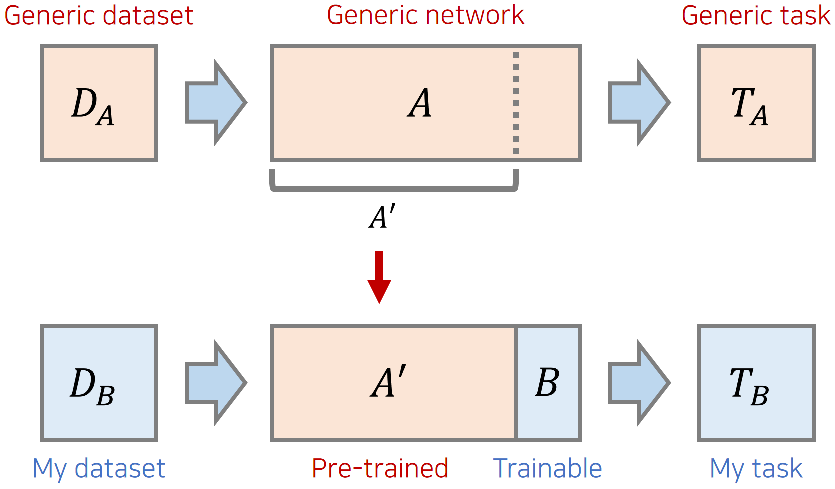

* 학습을 위해 필요한 라이브러리를 불러옵니다.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

* 데이터셋을 불러옵니다.

In [9]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 178
테스트 데이터셋 크기: 60
클래스: ['국수', '떡국', '만두', '밥', '수제비', '죽']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* 간단히 이미지를 시각화해 봅시다.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


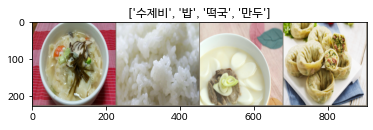

In [10]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

* 학습할 CNN 딥러닝 모델 객체를 초기화합니다.

In [11]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 6)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

* 학습을 진행합니다.

In [12]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#0 Loss: 1.5510 Acc: 41.5730% Time: 6.2599s
#1 Loss: 0.6486 Acc: 76.9663% Time: 12.3821s
#2 Loss: 0.4750 Acc: 85.9551% Time: 18.4435s
#3 Loss: 0.5243 Acc: 82.0225% Time: 24.5324s
#4 Loss: 0.3594 Acc: 88.2022% Time: 30.6066s
#5 Loss: 0.1838 Acc: 94.3820% Time: 36.5510s
#6 Loss: 0.3123 Acc: 90.4494% Time: 42.7132s
#7 Loss: 0.2447 Acc: 94.3820% Time: 48.6407s
#8 Loss: 0.2058 Acc: 92.6966% Time: 54.6067s
#9 Loss: 0.1633 Acc: 94.3820% Time: 60.5752s
#10 Loss: 0.3092 Acc: 89.3258% Time: 66.5282s
#11 Loss: 0.1625 Acc: 94.9438% Time: 72.4918s
#12 Loss: 0.1615 Acc: 93.8202% Time: 78.4268s
#13 Loss: 0.0823 Acc: 97.7528% Time: 84.4182s
#14 Loss: 0.2538 Acc: 91.0112% Time: 90.3638s
#15 Loss: 0.1514 Acc: 93.8202% Time: 96.4052s
#16 Loss: 0.3653 Acc: 88.7640% Time: 102.3444s
#17 Loss: 0.1581 Acc: 94.9438% Time: 108.3492s
#18 Loss: 0.0647 Acc: 97.1910% Time: 114.3518s
#19 Loss: 0.1367 Acc: 97.1910% Time: 120.3155s
#20 Loss: 0.1226 Acc: 95.5056% Time: 126.3051s
#21 Loss: 0.0538 Acc: 97.7528% Time: 132

* 학습된 모델을 평가합니다.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[예측 결과: 밥] (실제 정답: 밥)


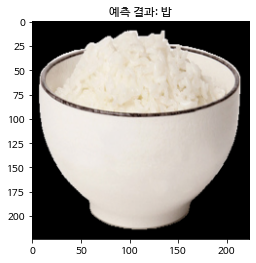

[예측 결과: 밥] (실제 정답: 밥)


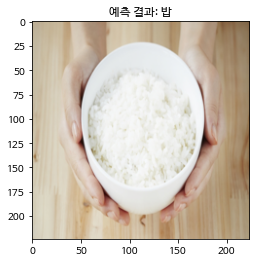

[예측 결과: 국수] (실제 정답: 국수)


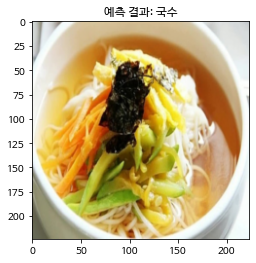

[예측 결과: 만두] (실제 정답: 만두)


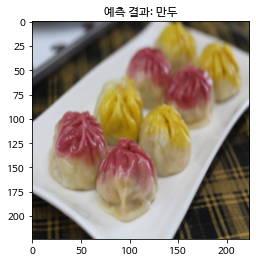

[예측 결과: 떡국] (실제 정답: 떡국)


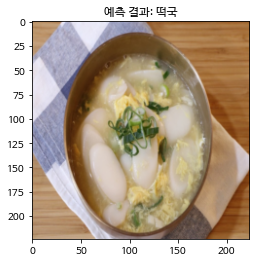

[예측 결과: 죽] (실제 정답: 죽)


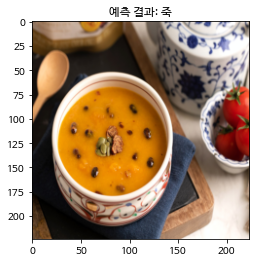

[예측 결과: 국수] (실제 정답: 국수)


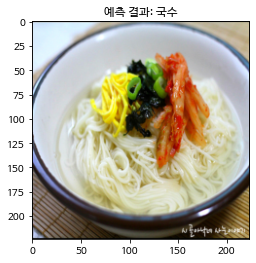

[예측 결과: 죽] (실제 정답: 죽)


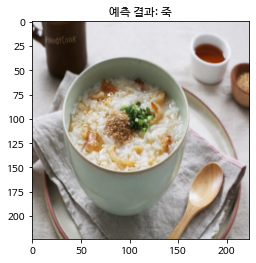

[예측 결과: 수제비] (실제 정답: 수제비)


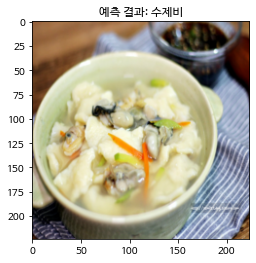

[예측 결과: 국수] (실제 정답: 국수)


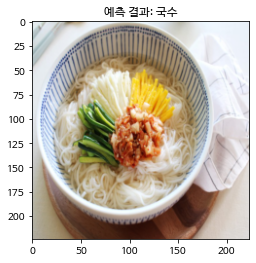

[예측 결과: 만두] (실제 정답: 죽)


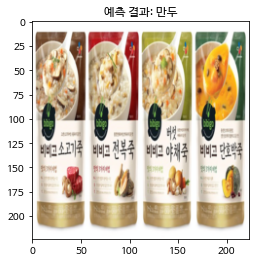

[예측 결과: 국수] (실제 정답: 국수)


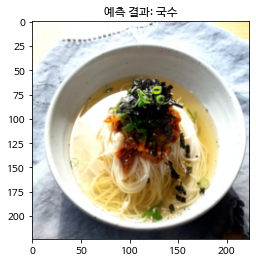

[예측 결과: 만두] (실제 정답: 만두)


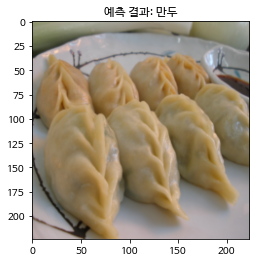

[예측 결과: 밥] (실제 정답: 밥)


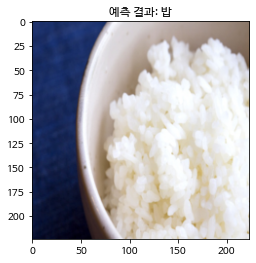

[예측 결과: 국수] (실제 정답: 수제비)


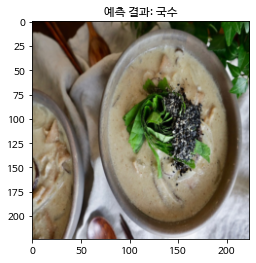

[Test Phase] Loss: 0.4661 Acc: 90.0000% Time: 4.7605s


In [13]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))